In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

import gc
from multiprocessing import Process, Queue

import os
import numpy as np
import pandas as pd
from datetime import date
from tqdm import tqdm

from sklearn.model_selection import KFold
from catboost import CatBoostClassifier
from catboost import CatBoostRegressor
from sklearn.metrics import confusion_matrix
from dateutil.relativedelta import relativedelta

import matplotlib.pyplot as plt
import multiprocessing as mp

pd.set_option('display.max_rows', 500)

store_stocks_dict = dict()
store_indexes_dict = dict()

## Loading and utils

### Basics

In [3]:
def update_stocks():
    os.system("rm mstcgl*.zip")
    #os.system("rm mstcgl.zip -d data/")
    os.system("wget https://info.bossa.pl/pub/ciagle/mstock/mstcgl.zip")
    os.system("rm -rf data/*")
    os.system("unzip mstcgl.zip -d data/")

    print(f'Updated {date.today()}, max actual date: \
    {prepare_data("WIG20", reset=True).index.max().strftime(format = "%Y-%m-%d")}')
    
    
def update_stocks_nc():
    os.system("rm mstncn.zip")
    #os.system("rm mstcgl.zip -d data/")
    os.system("wget https://info.bossa.pl/pub/newconnect/mstock/mstncn.zip")
    #os.system("rm -rf data/*")
    os.system("unzip mstncn.zip -d data/")

    print(f'Updated {date.today()}, max actual date: \
    {prepare_data("CLOUD", reset=True).index.max().strftime(format = "%Y-%m-%d")}')


def update_indexes():
    os.system("rm mstzgr*.zip")
    #os.system("rm mstzgr.zip -d data_for/")
    os.system("wget https://moja.info.bossa.pl/pub/indzagr/mstock/mstzgr.zip")
    os.system("rm -rf data_for/*")
    os.system("unzip mstzgr.zip -d data_for/")

    print(f'Updated {date.today()}, max actual date: \
    {prepare_index("NIKKEI").index.max().strftime(format = "%Y-%m-%d")}')


def prepare_data(paper, reset=False):

    if 'mst' in paper:
        paper = str(paper).rstrip('.mst')

    if (paper in store_stocks_dict.keys()) & (reset==False):
        df = store_stocks_dict[paper].copy()
    else:
        df = pd.read_csv(f'data/{paper}.mst')

        df.columns = [str(c).replace('<', '') for c in df.columns]
        df.columns = [str(c).replace('>', '') for c in df.columns]

        df.loc[:, 'DTYYYYMMDD'] = pd.to_datetime(df.loc[:, 'DTYYYYMMDD'],
                                                 format='%Y%m%d')

        df = df.set_index('DTYYYYMMDD')

        store_stocks_dict[paper] = df.copy()

    return df


def prepare_index(indeks, reset=False):

    if 'mst' in indeks:
        indeks = str(indeks).rstrip('.mst')

    if (indeks in store_indexes_dict.keys()) & (reset==False):
        df = store_indexes_dict[indeks].copy()
    else:
        df = pd.read_csv(f'data_for/{indeks}.mst')

        df.columns = [str(c).replace('<', '') for c in df.columns]
        df.columns = [str(c).replace('>', '') for c in df.columns]

        df.loc[:, 'DTYYYYMMDD'] = pd.to_datetime(df.loc[:, 'DTYYYYMMDD'],
                                                 format='%Y%m%d')

        df = df.set_index('DTYYYYMMDD')

        store_indexes_dict[indeks] = df.copy()

    return df

### dates and special papers to monitor

In [2]:
before_crises = '2020-02-15'
big_drop_date = '2020-03-12'
today = str(date.today())

watch = ['PZU','AMREST','KGHM', 'ASSECOSEE', 'NORTCOAST', 'CDPROJEKT', 
         'VOTUM', 'NEWAG', 'KRUSZWICA', 'INTERAOLT', 'PLAY', 'ARCHICOM', 'LPP', 'ARCTIC', 'PGNIG','TAURONPE', 
         'PKOBP', 'JSW','INTERCARS','BIOMEDLUB','PKOBP','PEKAO','SUNEX','INTERCARS','WIELTON']

watch_af = ['KGHM','KRUK', 'PKNORLEN',
            'ENEA','MBANK', 'PKOBP', 'WIELTON', 
            'ARCHICOM', 'ARCTIC', 'CFI', 'RONSON','TORPOL', 'XTB']

#gold_list = [a for a in all_stocks if 'GOLD' in a]

#watch_af = watch_af + gold_list

## Do updates

In [4]:
update_indexes()
update_stocks()
update_stocks_nc()

all_stocks = os.listdir('data/')
all_indekses = os.listdir('data_for/')
print(
    f'no of all available stock: {len(all_stocks)} and indexes: {len(all_indekses)}'
)

Updated 2020-07-21, max actual date:     2020-07-20
Updated 2020-07-21, max actual date:     2020-07-21
Updated 2020-07-21, max actual date:     2020-07-21
no of all available stock: 2426 and indexes: 23


## Single plot

### Plot code

In [10]:
def plot_paper(papier, plot_range_min, plot_range_max):
    df = prepare_data(papier)

    plot_df = df.loc[(df.index >= plot_range_min) & 
                     (df.index <= plot_range_max),:].copy()
    if not plot_df.shape[0]:
        return 'Nothing to show!'

    spread = (plot_df.loc[:,'CLOSE'].max() - plot_df.loc[:,'CLOSE'].min()) / 14

    plot_df.loc[:,'CLOSE_diff'] = ((plot_df.loc[:,'CLOSE']
                                                - plot_df.loc[:,'CLOSE'].shift(1))
                                                / plot_df.loc[:,'CLOSE'].shift(1)) * 100

    plot_df_bar = ((plot_df.loc[:,'VOL'] - plot_df.loc[:,'VOL'].mean()) 
               / plot_df.loc[:,'VOL'].std() * spread)
    plot_df_bar = plot_df_bar + abs(plot_df_bar.min())
    plot_bar_bottom = plot_df.loc[:,'CLOSE'].min() - plot_df_bar.max()

    plot_df_vol_close = (plot_df.loc[:,'VOL'].rolling(3).mean() * 
             plot_df.loc[:,'CLOSE_diff'].rolling(3).mean())
    plot_df_vol_close = ((plot_df_vol_close - plot_df_vol_close.mean()) 
                         / plot_df_vol_close.std()) * spread
    plot_df_vol_close = plot_df_vol_close + (plot_bar_bottom - plot_df_vol_close.max())
    
    bottom_date = plot_df.loc[plot_df.loc[:,'CLOSE'] 
                              == plot_df.loc[:,'CLOSE'].min()].index.strftime('')[0]


    plt.figure(figsize=(20,10))
    plt.plot(plot_df.loc[:,'CLOSE'])
    plt.plot(plot_df_vol_close)

    plt.bar(plot_df_bar.index, 
            plot_df_bar.values,
           bottom = plot_bar_bottom)

    plt.hlines(plot_df.loc[:,'CLOSE'].min(), 
               plot_range_min, plot_range_max, 
               linestyles='--', 
               colors='blue')
#     plt.hlines(plot_df.loc[plot_df.index >= bottom_date,'CLOSE'].max(), 
#                plot_range_min, plot_range_max, 
#                linestyles='--', 
#                colors='red')
    plt.hlines(plot_df.loc[:,'CLOSE'].min()*1.2, 
               plot_range_min, plot_range_max, 
               linestyles='--', 
               colors='red')
    plt.hlines(plot_df.loc[:,'CLOSE'].min()*1.1, 
           plot_range_min, plot_range_max, 
           linestyles='--', 
           colors='orange')
    
    plt.xticks(rotation=15)
    plt.legend([df.TICKER[0],
                'volumen * close',
               'minimum',
               'min + 20%',
               'volumen'])
    plt.show()
    
def prepare_stats_forone(papier, before_crises, big_drop_date):
    
    df = prepare_data(papier)
    df = df.loc[df.index >= '2020-01-01',:]
    
    current = df.tail(1).CLOSE

    
    data_max_before_crisis = df.loc[(df.index <= before_crises) &
                                 (df.index >= '2020-01-01'),"CLOSE"].max()
    data_max_after_drop = df.loc[df.index >= big_drop_date,"CLOSE"].max()
    data_min_after_max = df.loc[df.index >= 
                                df.loc[df.loc[:,'CLOSE'] == data_max_after_drop].index[0], 
                                'CLOSE']
    data_crises_min = df.loc[(df.index <= big_drop_date) & 
           (df.index >= before_crises),"CLOSE"].min()
    
    #dates
    date_max_after_drop = df.loc[df.loc[:,'CLOSE'] == data_max_after_drop,:].index
    
    return (current, data_max_before_crisis, data_crises_min, data_max_after_drop, data_min_after_max,
           date_max_after_drop)

### Just plot

In [7]:
#[a for a in all_stocks if 'GOLD' in a]

In [8]:
papier = 'RCFL5GOLD'

In [9]:
#plot_paper(papier,'2008-07-15','2008-11-15')

/home/showletter/.local/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


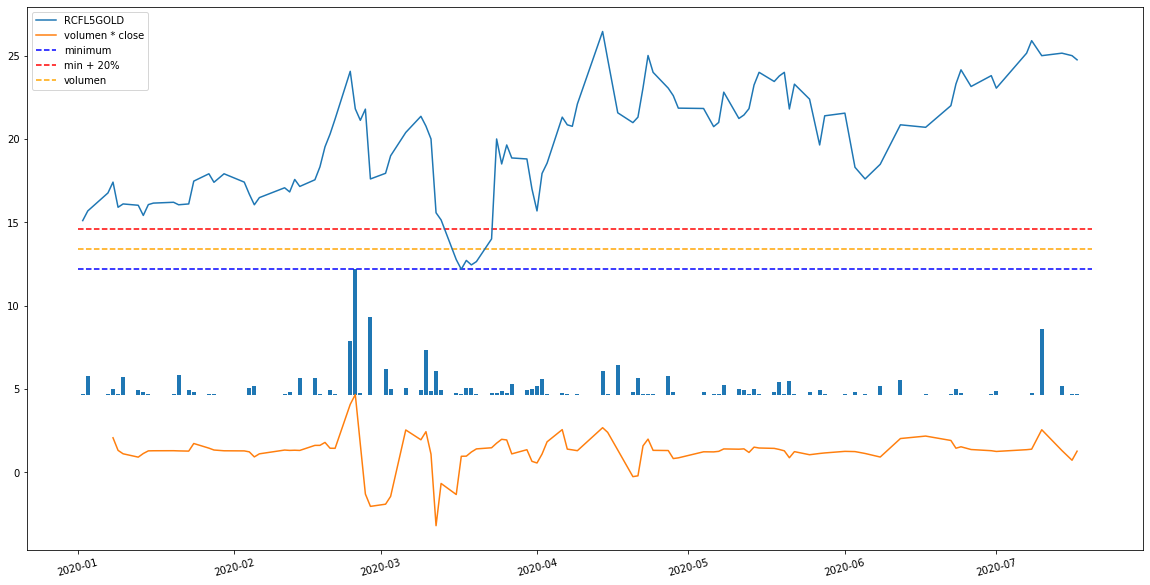

In [11]:
plot_paper(papier,'2020-01-01', str(date.today()))

In [13]:
(current,
data_max_before_crisis,
 data_crises_min,
 data_max_after_drop,
 data_min_after_max,
date_max_after_drop) = prepare_stats_forone(papier, before_crises, big_drop_date)

print(f'Paper: {papier}, currently at {current[0]}, with potential \
{round(data_max_before_crisis*100/current[0]-100, 2)}% to top')
print(f'Max before crisis: {data_max_before_crisis}')
print(f'Crisis bottom: {data_crises_min}')
print(f'Max after crisis drop: {data_max_after_drop}, at {date_max_after_drop[0]}')
print(f'Stats after Max: {data_min_after_max.values}')

Paper: RCFL5GOLD, currently at 24.75, with potential -27.64% to top
Max before crisis: 17.91
Crisis bottom: 15.57
Max after crisis drop: 26.45, at 2020-04-14 00:00:00
Stats after Max: [26.45 24.8  21.57 20.98 21.31 23.06 25.01 24.   23.05 22.6  21.85 21.83
 20.74 20.99 22.81 21.23 21.44 21.82 23.24 24.   23.45 23.78 24.   21.8
 23.29 22.39 19.64 21.39 21.55 18.3  17.6  18.48 20.85 20.7  22.   23.3
 24.15 23.15 23.8  23.05 25.15 25.9  25.   25.15 25.   24.75]


## Skaner

#### skaner defs

In [5]:
before_crisis = '2020-02-17'
top_bottom = '2020-03-12'
new_year = '2020-01-01'
last_y_quarter = '2019-10-01'
last_y_mid = '2019-06-03'
today = str(date.today())

df_cols = [
    'ticker', 'current', 'mean_VOL', 'before_crisis', 'last_y_q', 'last_y_mid',
    'crisis_bottom', 'max_after_crisis', 'max_before_crisis'
]

### All papers

In [6]:
skaner_df = pd.DataFrame(columns=df_cols)
for w in tqdm(all_stocks):
    
    df = prepare_data(w)
   
    skaner_df = pd.concat([skaner_df,
                       pd.DataFrame([[
                    df.TICKER[0],
                    df.loc[:,'CLOSE'].tail(1).values[0],
                    df.loc[df.index > '2020-03-01' ,'VOL'].mean(),
                    df.loc[df.index == before_crisis ,'CLOSE'].max(),
                    df.loc[df.index == last_y_quarter ,'CLOSE'].max(),
                           df.loc[df.index == last_y_mid,'CLOSE'].max(),
                    df.loc[(df.index >= top_bottom) & (df.index <= today),'CLOSE'].min(),
                    df.loc[df.index > top_bottom ,'CLOSE'].max(),
                    df.loc[(df.index >= last_y_quarter) & (df.index <= before_crisis),'CLOSE'].max()
                    
                       ]],
                                    columns=df_cols)], axis = 0)

skaner_df.loc[:,'growth_quarter'] = round(skaner_df.loc[:,'before_crisis'] * 100 / skaner_df.loc[:,'last_y_q'] - 100, 2)
skaner_df.loc[:,'growth_mid'] = round(skaner_df.loc[:,'last_y_q'] * 100 / skaner_df.loc[:,'last_y_mid'] - 100, 2)
skaner_df.loc[:,'growth_from_crisis'] = round(skaner_df.loc[:,'max_after_crisis'] * 100 / skaner_df.loc[:,'crisis_bottom'] - 100, 2)
skaner_df.loc[:,'growth_current'] = round(skaner_df.loc[:,'current'] * 100 / skaner_df.loc[:,'crisis_bottom'] - 100, 2)
skaner_df.loc[:,'growth_potential'] = round((skaner_df.loc[:,'max_before_crisis'] * 100) / skaner_df.loc[:,'current'] - 100, 2)
skaner_df.loc[:,'drop_current'] = round(skaner_df.loc[:,'current'] * 100 / skaner_df.loc[:,'max_before_crisis'] - 100, 2)

skaner_df = skaner_df.loc[
    skaner_df.ticker.apply(lambda x: 
                               False if ('RCFL' in x) 
                               | ('INTLGLD' in x) 
                               | ('RCFS' in x)
                               | ('INTL' in x)
                               | ('INTS' in x)
                               | ('RCTL' in x)
                               | ('BETA' in x)
                               | ('DVP' in x)
                               | ('RCT' in x)
                               | ('RCS' in x)
                               | ('RCR' in x)
                               | ('RCB' in x)
                               | ('WIG' in x)
                               | ('PBSK' in x)
                               | ('RCL' in x) else True).values,]

100%|██████████| 2426/2426 [00:15<00:00, 156.81it/s]


In [8]:
skaner_df_see = skaner_df.loc[
    #(skaner_df.growth_quarter > 0) 
        #& (skaner_df.growth_mid > 0) 
        #& (skaner_df.drop_current < 0) 
        #(skaner_df.growth_current > -100)
    (skaner_df.mean_VOL > 10000)
                              ,:].sort_values('drop_current', ascending=True)

skaner_df_see = skaner_df_see.dropna().copy()

print(skaner_df_see.dropna().shape)

(266, 15)


In [9]:
#skaner_df.loc[skaner_df.ticker.apply(lambda x: True if ('GOLD' in x) else False),]

## Model

In [10]:
### ADD WIG20 DAY BEFORE!

def transform_one_paper_ch(df):
    
    for col in ['OPEN', 'LOW', 'HIGH', 'CLOSE', 'VOL']:
        df.loc[:,col + '_shifted'] = df.loc[:,col].shift(1)
        df.loc[:,'chng_' + col] = np.nan
        df.loc[:,'chng_' + col] = (df.loc[:,col] * 100 / df.loc[:,col + '_shifted']) - 100
        
    df.loc[:,'move_strength_abs'] =  abs(df.loc[:,'chng_CLOSE']) * abs(df.loc[:,'chng_VOL'])
    df.loc[:,'move_strength'] =  (df.loc[:,'chng_CLOSE']) * (df.loc[:,'chng_VOL'])
    
    
### COMPARISON SECTION
#are you on losing strike?
#str strike
    for col in ['OPEN', 'LOW', 'HIGH', 'CLOSE', 'VOL']:
        for i in [5, 10, 20, 30, 60, 120, 240]:
            df.loc[:,f'comp{i}d_max' + col] = df.loc[:,col].rolling(i).max()
            df.loc[:,f'comp{i}d_max' + col] = (df.loc[:,col] * 100 / df.loc[:,f'comp{i}d_max' + col]) - 100
            
            df.loc[:,f'comp{i}d_min' + col] = df.loc[:,col].rolling(i).min()
            df.loc[:,f'comp{i}d_min' + col] = (df.loc[:,col] * 100 / df.loc[:,f'comp{i}d_min' + col]) - 100
            
            df.loc[:,f'comp{i}d_mean' + col] = df.loc[:,col].rolling(i).mean()
            df.loc[:,f'comp{i}d_mean' + col] = (df.loc[:,col] * 100 / df.loc[:,f'comp{i}d_mean' + col]) - 100
            
            df.loc[:,f'comp{i}d_std' + col] = df.loc[:,col].rolling(i).std()
            df.loc[:,f'comp{i}d_std' + col] = (df.loc[:,col] * 100 / df.loc[:,f'comp{i}d_std' + col]) - 100
            
    
#     for col in ['OPEN', 'LOW', 'HIGH', 'CLOSE', 'VOL']:
#         cols = [f'comp{i}d_max' + col for i in [5,10,20]]
#         #df.loc[:,'all_higher_f'] = (df[cols] > 0).sum(axis = 1)
#         df.loc[:,'all_higher_cat'] = (df[cols] > 0).astype(str).sum(axis = 1)
        
#         cols = [f'comp{i}d_min' + col for i in [5,10,20]]
#         #df.loc[:,'all_lower_f'] = (df[cols] < 0).sum(axis = 1)
#         df.loc[:,'all_lower_cat'] = (df[cols] < 0).astype(str).sum(axis = 1)
    
            
### FUTURE SECTION ###

#     df.loc[df.loc[:, 'OPEN'].shift(-1) > df.loc[:, 'CLOSE'],'fut_CLOSE_OPEN1'] = 1
#     df.loc[df.loc[:, 'OPEN'].shift(-1) <= df.loc[:, 'CLOSE'],'fut_CLOSE_OPEN1'] = 0
    
    #df.loc[:, 'fut_OPEN_CLOSE_chng'] = (df.loc[:, 'OPEN'].shift(-1) * 100 / df.loc[:, 'CLOSE']) - 100
    
#     df.loc[:, 'chng_rel_OPEN'] = np.nan
#     df.loc[df.loc[:, 'HIGH'] > df.loc[:, 'OPEN'] * 1.01,'chng_rel_OPEN'] = 1
#     df.loc[df.loc[:, 'HIGH'] <= df.loc[:, 'OPEN'] * 1.01, 'chng_rel_OPEN'] = 0
    
#     df.loc[df.loc[:, 'OPEN'] < df.loc[:, 'HIGH'],'comp_HIGH_OPEN'] = 1
#     df.loc[df.loc[:, 'OPEN'] >= df.loc[:, 'HIGH'],'comp_HIGH_OPEN'] = 0


### DIFFS SECTION ###
    df.loc[:,'diff_LOW_HIGH'] = (df.loc[:,'HIGH'] - df.loc[:,'LOW']) / df.loc[:,'HIGH']
    df.loc[:,'diff_OPEN_CLOSE'] = (df.loc[:,'OPEN'] - df.loc[:,'CLOSE']) / df.loc[:,'CLOSE']
    df.loc[:,'diff_LOW_CLOSE'] = (df.loc[:,'CLOSE'] - df.loc[:,'LOW']) / df.loc[:,'CLOSE']
    df.loc[:,'diff_HIGH_CLOSE'] = (df.loc[:,'HIGH'] - df.loc[:,'CLOSE']) / df.loc[:,'CLOSE']
    
    
### HISTORIC SECTION ###

    for a in [c for c in df.columns if ('diff_' in c) | ('chng' in c) | ('chng_' in c)]:
        for i in [1, 2, 3]:
            df.loc[:,f'hist{i}_' + a] = df.loc[:,a].shift(i)

### GET SOME MEANS ###
#Trye min and maxes and some std?
    for b in [c for c in df.columns if (('chng_' in c) 
                                        | ('move_' in c) 
                                        | ('diff_' in c)
                                       | ('same_' in c)) & ('hist' not in c)]:
        for g in [2, 3, 5, 10, 20, 40, 80, 120, 240]:
            df.loc[:,f'roll{g}m_' + b] = df.loc[:,b].rolling(g).mean()
            df.loc[:,f'roll{g}min_' + b] = df.loc[:,b].rolling(g).min()
            df.loc[:,f'roll{g}max_' + b] = df.loc[:,b].rolling(g).max()
            df.loc[:,f'roll{g}std_' + b] = df.loc[:,b].rolling(g).std()


### SUBTARGET ###
#     df.loc[df.loc[:, 'OPEN'].shift(-1) > df.loc[:, 'CLOSE'],'subtarget'] = 1
#     df.loc[df.loc[:, 'OPEN'].shift(-1) <= df.loc[:, 'CLOSE'],'subtarget'] = 0
            
### TARGET SECTION ###
#pick one the of the available sections

## HIGHER HIGH ###
#     df.loc[df.loc[:, 'HIGH'].shift(-1) > df.loc[:, 'HIGH'],'target'] = 1
#     df.loc[df.loc[:, 'HIGH'].shift(-1) <= df.loc[:, 'HIGH'],'target'] = 0

### LOWER LOW ###
#     df.loc[df.loc[:, 'LOW'].shift(-1) < df.loc[:, 'LOW'],'target'] = 1
#     df.loc[df.loc[:, 'LOW'].shift(-1) >= df.loc[:, 'LOW'],'target'] = 0
    
### HIGHER OPENING ###
#     df.loc[df.loc[:, 'OPEN'].shift(-1) > df.loc[:, 'CLOSE'],'target'] = 1
#     df.loc[df.loc[:, 'OPEN'].shift(-1) <= df.loc[:, 'CLOSE'],'target'] = 0
    
# ### HIGHER CLOSING THAN OPENING ###
#     df.loc[df.loc[:, 'CLOSE'].shift(-1) > df.loc[:, 'OPEN'].shift(-1),'target'] = 1
#     df.loc[df.loc[:, 'CLOSE'].shift(-1) <= df.loc[:, 'OPEN'].shift(-1),'target'] = 0

# ### OPENING NOT FAR FROM LOW ###
#     df.loc[df.loc[:, 'OPEN'].shift(-1)*0.99 > df.loc[:, 'LOW'].shift(-1),'target'] = 0
#     df.loc[df.loc[:, 'OPEN'].shift(-1)*0.99 <= df.loc[:, 'LOW'].shift(-1),'target'] = 1
    
### HIGH HIGHER MORE THAN 1% THAN OPENING ###
#     df.loc[df.loc[:, 'OPEN'].shift(-1)*1.01 < df.loc[:, 'HIGH'].shift(-1),'target'] = 1
#     df.loc[df.loc[:, 'OPEN'].shift(-1)*1.01 >=  df.loc[:, 'HIGH'].shift(-1),'target'] = 0
    
# ### HIGHER CLOSING THAN OPENING ###

#     df.loc[:, 'max_3d'] = df.loc[:, 'CLOSE'].rolling(3).max()
#     df.loc[df.loc[:, 'max_3d'].shift(-3) > df.loc[:, 'OPEN'].shift(-1)*1.05,'target'] = 1
#     df.loc[df.loc[:, 'max_3d'].shift(-3) <= df.loc[:, 'OPEN'].shift(-1)*1.05,'target'] = 0
    
#     df.loc[:, 'max_1d'] = df.loc[:, 'HIGH'].rolling(1).max()
#     df.loc[df.loc[:, 'max_1d'].shift(-1) > df.loc[:, 'OPEN'].shift(-1)*1.03,'target'] = 1
#     df.loc[df.loc[:, 'max_1d'].shift(-1) <= df.loc[:, 'OPEN'].shift(-1)*1.03,'target'] = 0

#     df.loc[:, 'CLOSE_shifted_20'] = df.loc[:, 'CLOSE'].shift(-20)
#     df.loc[df.loc[:, 'CLOSE_shifted_20'] > df.loc[:, 'OPEN'].shift(-1)*1.05,'target'] = 1
#     df.loc[df.loc[:, 'CLOSE_shifted_20'] <= df.loc[:, 'OPEN'].shift(-1)*1.05,'target'] = 0

#     df.loc[:, 'CLOSE_shifted_60'] = df.loc[:, 'CLOSE'].shift(-20)
#     #df.loc[:, 'CLOSE_mean_value60'] = df.loc[:, 'CLOSE'].rolling(5).mean()*1.05,
#     df.loc[df.loc[:, 'CLOSE_shifted_60'] > df.loc[:, 'CLOSE'].rolling(5).mean()*1.05,'target'] = 1
#     df.loc[df.loc[:, 'CLOSE_shifted_60'] <= df.loc[:, 'CLOSE'].rolling(5).mean()*1.05,'target'] = 0

#     df.loc[:, 'CLOSE_shifted_20'] = df.loc[:, 'CLOSE'].shift(-20)
#     #df.loc[:, 'CLOSE_mean_value60'] = df.loc[:, 'CLOSE'].rolling(5).mean()*1.05,
#     df.loc[df.loc[:, 'CLOSE_shifted_20'] > df.loc[:, 'CLOSE'],'target'] = 1
#     df.loc[df.loc[:, 'CLOSE_shifted_20'] <= df.loc[:, 'CLOSE'],'target'] = 0
    
#     df.loc[:, 'CLOSE_shifted_20'] = df.loc[:, 'CLOSE'].shift(-20)
#     #df.loc[:, 'CLOSE_mean_value60'] = df.loc[:, 'CLOSE'].rolling(5).mean()*1.05,
#     df.loc[df.loc[:, 'CLOSE_shifted_20'] > df.loc[:, 'CLOSE'],'target'] = 1
#     df.loc[df.loc[:, 'CLOSE_shifted_20'] <= df.loc[:, 'CLOSE'],'target'] = 0

# REGRESSION TARGET #


    df.loc[:, 'CLOSE_shifted_20'] = df.loc[:, 'CLOSE'].shift(-20)
    df.loc[:,'target'] = (df.loc[:, 'CLOSE_shifted_20'] * 100 / df.loc[:, 'CLOSE']) - 100
    
    return df

In [11]:
def f(q, res):
    while not (q.empty()):
        pap = q.get()
        df = prepare_data(pap)
        df = transform_one_paper_ch(df) 
        df = df.dropna()
        res.put(df)
    #print('done')
    
    
def put_res_together(resfin, res):
    
    while not (res.empty()):
        df_tofin = pd.DataFrame()
        #print(res.qsize())
        for i in range(10):
            try:
                df_one = res.get()
                df_tofin = pd.concat([df_tofin, df_one])
            except:
                resfin.put(df_tofin)
                break
        resfin.put(df_tofin)    
    #print('done')

q = Queue()
res = Queue()
resfin = Queue()

papers_to_train = list(watch + list(skaner_df_see.dropna().ticker.values) + watch_af)
papers_to_train = list(dict.fromkeys(papers_to_train ))

for w in (papers_to_train):
    q.put(w)

full_size = q.qsize()
total = q.qsize()
pbar = tqdm(total = total)

p = Process(target=f, args=(q, res))
p2 = Process(target=f, args=(q, res))
p3 = Process(target=f, args=(q, res))
p4 = Process(target=f, args=(q, res))
#p5 = Process(target=f, args=(q, res))
p.start()
p2.start()
p3.start()
p4.start()
#p5.start()

pbar.update(2)
while (res.qsize() != full_size):
    if total > q.qsize():
        pbar.update(1)
        total = q.qsize()
pbar.close()

100%|█████████▉| 272/273 [03:08<00:00,  1.44it/s]


In [12]:
pt = Process(target=put_res_together, args=(resfin, res))
pt2 = Process(target=put_res_together, args=(resfin, res))
pt3 = Process(target=put_res_together, args=(resfin, res))
pt4 = Process(target=put_res_together, args=(resfin, res))
pt.start()
pt2.start()
pt3.start()
pt4.start()

total = res.qsize()
pbar = tqdm(total = total)

pbar.update(1)
while(res.qsize()):
    if total > res.qsize():
        pbar.update(1)
        total = res.qsize()
pbar.close()

100%|██████████| 273/273 [00:08<00:00, 31.28it/s]


In [13]:
df_papers = pd.DataFrame()

total = resfin.qsize()
pbar = tqdm(total = total)

while not resfin.empty():
    df = resfin.get()
    df_papers = pd.concat([df_papers , df])
    pbar.update(1)
pbar.close()

100%|██████████| 25/25 [00:54<00:00,  2.20s/it]


In [14]:
p.terminate()
p2.terminate()
p3.terminate()
p4.terminate()
#p5.terminate()

pt.terminate()
pt2.terminate()
pt3.terminate()
pt4.terminate()


gc.collect()

58

In [15]:
#ADD INDEX MEANS!
def transform_one_index(df):
    for col in ['OPEN', 'LOW', 'HIGH', 'CLOSE', 'VOL']:
        df.loc[:,col + '_shifted'] = df.loc[:,col].shift(1)
        df.loc[:,'chng_' + col] = np.nan
        df.loc[:,'chng_' + col] = (df.loc[:,col] * 100 / df.loc[:,col + '_shifted']) - 100
    
    for b in ['chng_OPEN', 'chng_LOW', 'chng_HIGH', 'chng_CLOSE', 'chng_VOL']:    
        for g in [1, 2, 3, 5, 10, 20, 40, 80, 120, 240]:
            df.loc[:,f'idxroll{g}m_' + b] = df.loc[:,b].rolling(g).mean()
#             df.loc[:,f'idxroll{g}min_' + b] = df.loc[:,b].rolling(g).min()
#             df.loc[:,f'idxroll{g}max_' + b] = df.loc[:,b].rolling(g).max()
#             df.loc[:,f'idxroll{g}std_' + b] = df.loc[:,b].rolling(g).std()
    return df

In [16]:
df_indexes = pd.DataFrame()

for p in tqdm(all_indekses):
    
    df = prepare_index(p)
    df = transform_one_index(df) 
    
    #df = df.dropna()
    
    df_indexes = pd.concat([df_indexes, df])
    del df

df_indexes = (df_indexes.reset_index()
              .groupby('DTYYYYMMDD')
              .agg(['mean', 'max', 'std'])
              .dropna(how = 'all',axis = 1))
df_indexes = df_indexes.loc[:,[c for c in df_indexes.columns if 'roll' in c[0]]]
df_indexes.columns = ('foreign_stocks_' + df_indexes.columns.get_level_values(1) 
                      + '_chng_' 
                      + df_indexes.columns.get_level_values(0))
df_indexes = df_indexes.dropna(how = 'all',axis = 1)
df_indexes = df_indexes.loc[:,[c for c in df_indexes.columns if 'CLOSE' in c]]

100%|██████████| 23/23 [00:04<00:00,  5.60it/s]


In [151]:
df_merged = df_papers.merge(df_indexes, left_index=True, right_index=True, how = 'left')

train_cols = [c for c in df_merged.columns if ('chng' in c) | ('move' in c) 
              | ('comp' in c) | ('fut' in c) | ('diff' in c) | ('same' in c) | ('hist' in c)]

In [152]:
df_merged.loc[df_merged.target > 30,'target'] = 30
df_merged.loc[df_merged.target < -20,'target'] = -20

In [154]:
# df_merged = df_merged.loc[:,train_cols_limited + ['target']].copy()

# train_cols = [c for c in train_cols if c in train_cols_limited]

In [155]:
# valid = df_merged.loc[df_merged.index >= '2020-06-01'].copy()

# df_merged = df_merged.loc[df_merged.index < '2020-06-01']

cut_date = '2020-05-01'
train_data = df_merged.loc[df_merged.index < cut_date,train_cols]
eval_data = df_merged.loc[df_merged.index >= cut_date,train_cols]
train_labels = df_merged.loc[df_merged.index < cut_date,'target'].values
eval_labels = df_merged.loc[df_merged.index >= cut_date,'target'].values

In [156]:
#print(f"Target balance: {round(train_labels.sum() / train_labels.shape[0],2)}")

In [157]:
# def get_model():
#     # Initialize CatBoostClassifier
#     model = CatBoostClassifier(iterations=10000,
#                            learning_rate=0.03,
#                                bagging_temperature=3,
#                                l2_leaf_reg = 3,
#                                #max_leaves = 40,
#                                #grow_policy='Lossguide',
#                                #random_strength = 10,
#                                use_best_model=True,
#                                min_data_in_leaf=100,
#                                #sampling_frequency=1,
#                                #subsample = 0.9,
#                            depth=4,
#                                has_time=True,
#                           #thread_count=4,
#                           eval_metric='AUC',
#                           task_type='GPU')
#     return model

def get_model():
    # Initialize CatBoostClassifier
    model = CatBoostRegressor(iterations=10000,
                           learning_rate=0.03,
                               bagging_temperature=3,
                               l2_leaf_reg = 3,
                               #max_leaves = 40,
                               #grow_policy='Lossguide',
                               #random_strength = 10,
                               use_best_model=True,
                               min_data_in_leaf=100,
                               #sampling_frequency=1,
                               #subsample = 0.9,
                               depth=4,
                               has_time=True,
                          #thread_count=4,
                          eval_metric='RMSE',
                          task_type='GPU')
    return model

### Train

In [158]:
model = get_model()

model.fit(train_data, train_labels, #cat_features=[0, 1],
          #eval_set=[(train_data[:-1], train_labels[:-1]),(eval_data[:-1], eval_labels[:-1])],
          eval_set=[(eval_data, eval_labels)],
         early_stopping_rounds=100, use_best_model=True, verbose=10)

0:	learn: 11.8591807	test: 17.2835526	best: 17.2835526 (0)	total: 18.2ms	remaining: 3m 1s
10:	learn: 11.8014459	test: 17.1008651	best: 17.1008651 (10)	total: 200ms	remaining: 3m 1s
20:	learn: 11.7474898	test: 17.0503433	best: 17.0503433 (20)	total: 352ms	remaining: 2m 47s
30:	learn: 11.7126781	test: 16.9363181	best: 16.9363181 (30)	total: 488ms	remaining: 2m 36s
40:	learn: 11.6829577	test: 16.8625561	best: 16.8625561 (40)	total: 616ms	remaining: 2m 29s
50:	learn: 11.6519017	test: 16.8259032	best: 16.8259032 (50)	total: 737ms	remaining: 2m 23s
60:	learn: 11.6284716	test: 16.7886485	best: 16.7886485 (60)	total: 865ms	remaining: 2m 20s
70:	learn: 11.6053769	test: 16.7550308	best: 16.7550308 (70)	total: 988ms	remaining: 2m 18s
80:	learn: 11.5872552	test: 16.7456989	best: 16.7360358 (76)	total: 1.11s	remaining: 2m 16s
90:	learn: 11.5711726	test: 16.7610850	best: 16.7360358 (76)	total: 1.23s	remaining: 2m 13s
100:	learn: 11.5555001	test: 16.7751144	best: 16.7360358 (76)	total: 1.34s	remainin

In [159]:
model.get_feature_importance(prettified=True).head(10)

,Feature Id,Importances
0,foreign_stocks_mean_chng_idxroll240m_chng_CLOSE,15.258993
1,foreign_stocks_std_chng_idxroll240m_chng_CLOSE,9.946635
2,foreign_stocks_max_chng_idxroll240m_chng_CLOSE,9.461817
3,foreign_stocks_mean_chng_idxroll40m_chng_CLOSE,5.601294
4,foreign_stocks_max_chng_idxroll80m_chng_CLOSE,5.422827
5,foreign_stocks_std_chng_idxroll40m_chng_CLOSE,5.007909
6,foreign_stocks_mean_chng_idxroll10m_chng_CLOSE,4.340539
7,foreign_stocks_mean_chng_idxroll20m_chng_CLOSE,3.743938
8,foreign_stocks_max_chng_idxroll120m_chng_CLOSE,3.591117
9,roll240m_chng_LOW,3.492846


In [160]:
model.get_feature_importance(prettified=True).tail(10)

,Feature Id,Importances
594,foreign_stocks_max_chng_idxroll1m_chng_CLOSE,0.0
595,foreign_stocks_std_chng_idxroll1m_chng_CLOSE,0.0
596,foreign_stocks_max_chng_idxroll2m_chng_CLOSE,0.0
597,foreign_stocks_std_chng_idxroll2m_chng_CLOSE,0.0
598,foreign_stocks_max_chng_idxroll3m_chng_CLOSE,0.0
599,foreign_stocks_std_chng_idxroll3m_chng_CLOSE,0.0
600,foreign_stocks_max_chng_idxroll5m_chng_CLOSE,0.0
601,foreign_stocks_std_chng_idxroll5m_chng_CLOSE,0.0
602,foreign_stocks_std_chng_idxroll10m_chng_CLOSE,0.0
603,foreign_stocks_std_chng_idxroll20m_chng_CLOSE,0.0


In [128]:
imp = model.get_feature_importance(prettified=True)
train_cols_limited  = [c for c in train_cols if c in imp.loc[imp.Importances >= 0.01, 'Feature Id'].values]
#train_cols_limited = working_feats_785_on_high
len(train_cols) - len(train_cols_limited)

530

### Check eval

In [123]:
preds_class = model.predict(eval_data)
# Get predicted probabilities for each class
preds_proba = model.predict_proba(eval_data)
# Get predicted RawFormulaVal
preds_raw = model.predict(eval_data, prediction_type='RawFormulaVal')

preds = preds_class[:-1].astype(int)

In [124]:
preds = preds_proba[:,1].copy()

preds[preds > 0.5] = 1
preds[preds < 1] = 0
preds = preds[:-1].astype(int)

In [125]:
tn, fp, fn, tp = confusion_matrix(eval_labels[:-1].astype(int), preds).ravel()
(tn, fp, fn, tp)

(1667, 880, 3417, 2748)

In [126]:
tn / (tn + fn)

0.32789142407553107

In [127]:
tp / (tp + fp)

0.7574421168687983

In [128]:
df_res = pd.concat([pd.DataFrame(preds_proba), pd.Series(eval_labels)], axis=1)
df_res.columns = ['zero', 'one', 'true']
df_res.groupby('true').mean()

,zero,one
true,,
0.0,0.505447,0.494553
1.0,0.502863,0.497137


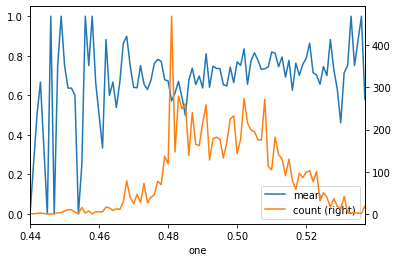

In [129]:
df_res.loc[:,'one'] = df_res.loc[:,'one'].round(3)
df_res.loc[:,'zero'] = df_res.loc[:,'zero'].round(3)
df_res_grouped = df_res.drop('zero', axis = 1)

# df_res_grouped.loc[df_res_grouped.one <= 0.3,'one'] = 0.3
# df_res_grouped.loc[df_res_grouped.one >= 0.54,'one'] = 0.55
df_res_grouped = df_res_grouped.groupby('one').agg(['mean', 'count'])
df_res_grouped.columns = df_res_grouped.columns.get_level_values(1)
df_res_grouped = df_res_grouped.reset_index().set_index('one')

df_res_grouped.plot(secondary_y='count')
plt.xticks(rotation=60)
plt.show()

In [130]:
df_res_grouped = df_res_grouped.reset_index()
df_res_grouped.columns = ['model_prob', 'trub_prob', 'test_count']

In [131]:
df_res_grouped

,model_prob,trub_prob,test_count
0,0.440,0.000000,1
1,0.442,0.500000,2
2,0.443,0.666667,3
3,0.445,0.000000,1
4,0.446,1.000000,1
5,0.447,0.000000,1
6,0.448,0.750000,4
7,0.449,1.000000,4
8,0.450,0.750000,8
9,0.451,0.636364,11


#### Predict regression

In [181]:
preds = model.predict(eval_data)

In [182]:
df_res = pd.concat([pd.DataFrame(preds), pd.Series(eval_labels)], axis=1)

In [183]:
df_res.columns = ['preds', 'true']

In [184]:
check_val = 1

In [185]:
df_res.loc[(df_res.preds > check_val) & (df_res.true > check_val)].shape[0] / \
df_res.loc[(df_res.true > check_val)].shape[0]

0.7551542000340774

In [166]:
df_res.loc[:,'true'] = df_res.true.round()

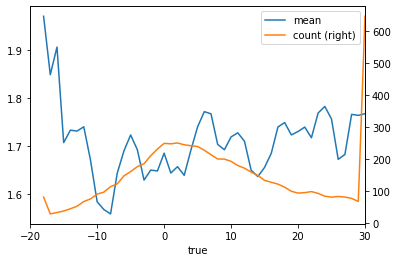

In [170]:
df_res.groupby('true').agg(['mean', 'count'])['preds'].plot(secondary_y='count')

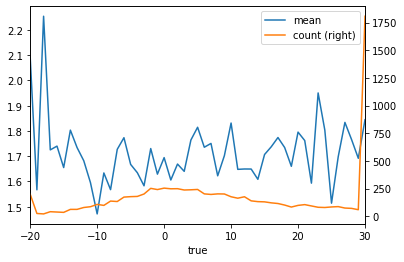

In [176]:
df_res.groupby('true').agg(['mean', 'count'])['preds'].plot(secondary_y='count')

In [186]:
df_res.loc[:,'preds'] = df_res.preds.round()

In [187]:
df_res.groupby('preds').agg(['mean', 'count'])['true']

,mean,count
preds,,
-2.0,30.000000,1
-1.0,15.534925,57
0.0,8.769307,858
1.0,8.790014,2746
2.0,10.294170,3038
3.0,10.849027,1503
4.0,10.379298,294
5.0,10.412898,76
6.0,7.286524,10


In [192]:
df_res_grouped = df_res.groupby('preds').agg(['mean', 'count'])['true']

In [195]:
df_res_grouped = df_res_grouped.reset_index()

In [197]:
df_res_grouped.columns = ['preds', 'true_vals', 'count']

### Check valid

In [61]:
valid_data = valid.loc[:,train_cols]
valid_labels = valid.loc[:,'target'].values

preds_class = model.predict(valid_data)
# Get predicted probabilities for each class

preds = preds_class[:-1].astype(int)

In [62]:
preds_proba = model.predict_proba(valid_data)

preds = preds_proba[:,1].copy()

preds[preds > 0.5] = 1
preds[preds < 1] = 0
preds = preds[:-1].astype(int)

In [63]:
tn, fp, fn, tp = confusion_matrix(valid_labels[:-1].astype(int), preds).ravel()
(tn, fp, fn, tp)

ValueError: not enough values to unpack (expected 4, got 0)

In [97]:
(tn + tp) / (tn + tp + fp + fn)

0.6321656050955414

In [98]:
tp / (tp + fp)

/usr/lib/python3/dist-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in long_scalars
  """Entry point for launching an IPython kernel.


nan

In [35]:
(tp / preds.shape[0]) * 100

7.973856209150326

### Prediction

In [177]:
def transform_results(qpapers, qtransformed, model):
    while not (qpapers.empty()):
        pap = qpapers.get()
        #print(pap)
        df = prepare_data(pap)
        df = transform_one_paper_ch(df) 
        
        df = df.merge(df_indexes,
              left_index=True,
              right_index=True,
              how='left')

        df.loc[:, 'pred_prob'] = model.predict(df[train_cols])
        #df.loc[:, 'pred_prob'] = model.predict_proba(df[train_cols])[:, 1]

        df.loc[:, 'fut_OPEN'] = df.loc[:, 'OPEN'].shift(-1)
        df.loc[:, 'fut_CLOSE'] = df.loc[:, 'CLOSE'].shift(-1)
        df.loc[:, 'fut_LOW'] = df.loc[:, 'LOW'].shift(-1)
        df.loc[:, 'fut_HIGH'] = df.loc[:, 'HIGH'].shift(-1)
        
        df.loc[:, 'fut5_CLOSE'] = df.loc[:, 'CLOSE'].shift(-5)
        df.loc[:, 'max_5d'] = df.loc[:, 'CLOSE'].rolling(5).max()
        
        df.loc[:, 'fut10_CLOSE'] = df.loc[:, 'CLOSE'].shift(-10)
        df.loc[:, 'max_10d'] = df.loc[:, 'CLOSE'].rolling(10).max()
        
        df.loc[:, 'fOPEN_fHIGH_chng'] = (df.loc[:, 'fut_HIGH'] * 100 /
                                 df.loc[:, 'fut_OPEN']) - 100
        df.loc[:, 'fOPEN_fCLOSE_chng'] = (df.loc[:, 'fut_CLOSE'] * 100 /
                                 df.loc[:, 'fut_OPEN']) - 100
        df.loc[:, 'CLOSE_fOPEN_chng'] = (df.loc[:, 'fut_OPEN'] * 100 /
                                         df.loc[:, 'CLOSE']) - 100
        df.loc[:, 'HIGH_fHIGH_chng'] = (df.loc[:, 'fut_HIGH'] * 100 /
                         df.loc[:, 'HIGH']) - 100
        df.loc[:, 'LOW_fLOW_chng'] = (df.loc[:, 'fut_LOW'] * 100 /
                 df.loc[:, 'LOW']) - 100
        
        df.loc[:, 'fOPEN_f10CLOSE_chng'] = (df.loc[:, 'fut10_CLOSE'] * 100 /
             df.loc[:, 'fut_OPEN']) - 100
        
        df.loc[:, 'fOPEN_f10MAX_chng'] = (df.loc[:, 'max_10d'].shift(-10) * 100 /
             df.loc[:, 'fut_OPEN']) - 100
        
        df.loc[:, 'fOPEN_f5CLOSE_chng'] = (df.loc[:, 'fut5_CLOSE'] * 100 /
             df.loc[:, 'fut_OPEN']) - 100
        
        df.loc[:, 'fOPEN_f5MAX_chng'] = (df.loc[:, 'max_5d'].shift(-5) * 100 /
             df.loc[:, 'fut_OPEN']) - 100
    

        one_res = df.reset_index().loc[:, [
            'DTYYYYMMDD', 'TICKER', 'OPEN', 'LOW', 'HIGH', 'CLOSE', 
           'fut_OPEN', 'fut_LOW', 'fut_HIGH', 'fut_CLOSE', 'fOPEN_fHIGH_chng', 
            'fOPEN_fCLOSE_chng', 'CLOSE_fOPEN_chng', 'HIGH_fHIGH_chng', 'LOW_fLOW_chng', 
            'fOPEN_f5CLOSE_chng', 'fOPEN_f5MAX_chng',
            'fOPEN_f10CLOSE_chng', 'fOPEN_f10MAX_chng', 'pred_prob']
                                      ].tail(30)
    
        #if one_res.shape == (15, 16):
        qtransformed.put(one_res)
    
    
def put_res_results_together(resfin, res):
    
    while not (res.empty()):
        df_tofin = pd.DataFrame()
        #print(res.qsize())
        for i in range(10):
            try:
                df_one = res.get()
                df_tofin = pd.concat([df_tofin, df_one])
            except:
                resfin.put(df_tofin)
                break
        resfin.put(df_tofin)    
    #print('done')

In [178]:
qpapers = Queue()
qtransformed = Queue()

papers_to_pred = list(watch + list(skaner_df_see.dropna().ticker.values) + watch_af)
papers_to_pred = list(dict.fromkeys(papers_to_train ))

for w in papers_to_pred:
    qpapers.put(w)

total = qpapers.qsize()
full_size = qpapers.qsize()

#%%time
p = Process(target=transform_results, args=(qpapers, qtransformed, model))
p2 = Process(target=transform_results, args=(qpapers, qtransformed, model))
p3 = Process(target=transform_results, args=(qpapers, qtransformed, model))
p4 = Process(target=transform_results, args=(qpapers, qtransformed, model))
#p5 = Process(target=transform_results, args=(qpapers, qtransformed, model))
p.start()
p2.start()
p3.start()
p4.start()
#p5.start()


pbar = tqdm(total = total)

while not qpapers.empty():
    if total > qpapers.qsize():
        pbar.update(1)
        #print(total)
        total = qpapers.qsize()
pbar.close()



  0%|          | 0/273 [00:00<?, ?it/s]

  1%|          | 2/273 [00:02<05:49,  1.29s/it]

  1%|          | 3/273 [00:03<04:49,  1.07s/it]

  1%|▏         | 4/273 [00:03<03:43,  1.21it/s]

  2%|▏         | 5/273 [00:04<04:05,  1.09it/s]

  2%|▏         | 6/273 [00:05<04:42,  1.06s/it]

  3%|▎         | 7/273 [00:06<03:54,  1.13it/s]

  3%|▎         | 8/273 [00:06<03:20,  1.32it/s]

  3%|▎         | 9/273 [00:08<04:01,  1.09it/s]

  4%|▎         | 10/273 [00:08<03:18,  1.33it/s]

  4%|▍         | 11/273 [00:08<02:28,  1.76it/s]

  4%|▍         | 12/273 [00:09<03:27,  1.26it/s]

  5%|▌         | 14/273 [00:11<03:20,  1.29it/s]

  5%|▌         | 15/273 [00:12<03:30,  1.23it/s]

  6%|▌         | 16/273 [00:12<02:58,  1.44it/s]

  6%|▌         | 17/273 [00:13<02:50,  1.50it/s]

  7%|▋         | 18/273 [00:14<03:53,  1.09it/s]

  7%|▋         | 19/273 [00:14<02:51,  1.49it/s]

  7%|▋         | 20/273 [00:15<03:12,  1.31it/s]

  8%|▊         | 21/273 [00:16<02:35,  1.62it/s]

  8%|▊         

 58%|█████▊    | 159/273 [02:04<00:54,  2.07it/s]

 59%|█████▊    | 160/273 [02:04<00:50,  2.23it/s]

 59%|█████▉    | 161/273 [02:05<01:20,  1.39it/s]

 59%|█████▉    | 162/273 [02:06<01:17,  1.43it/s]

 60%|█████▉    | 163/273 [02:07<01:10,  1.56it/s]

 60%|██████    | 164/273 [02:07<00:56,  1.94it/s]

 61%|██████    | 166/273 [02:09<01:10,  1.51it/s]

 61%|██████    | 167/273 [02:09<00:55,  1.90it/s]

 62%|██████▏   | 168/273 [02:10<01:03,  1.66it/s]

 62%|██████▏   | 169/273 [02:11<01:08,  1.53it/s]

 62%|██████▏   | 170/273 [02:11<01:03,  1.63it/s]

 63%|██████▎   | 171/273 [02:11<00:50,  2.04it/s]

 63%|██████▎   | 172/273 [02:12<01:05,  1.54it/s]

 63%|██████▎   | 173/273 [02:14<01:24,  1.18it/s]

 64%|██████▎   | 174/273 [02:14<01:12,  1.37it/s]

 64%|██████▍   | 175/273 [02:15<01:24,  1.16it/s]

 64%|██████▍   | 176/273 [02:15<01:04,  1.51it/s]

 65%|██████▍   | 177/273 [02:16<00:56,  1.69it/s]

 65%|██████▌   | 178/273 [02:17<01:11,  1.34it/s]

 66%|██████▌   | 179/273 [02:18

In [189]:
res = pd.DataFrame()
for i in tqdm(range(qtransformed.qsize())):
    df = qtransformed.get()
    #print(df.TICKER.values[0])
    res = pd.concat([res, df])
    #print(res.shape)



  0%|          | 0/273 [00:00<?, ?it/s]

 43%|████▎     | 118/273 [00:00<00:00, 1169.85it/s]

100%|██████████| 273/273 [00:00<00:00, 1105.21it/s]


In [190]:
p.terminate()
p2.terminate()
p3.terminate()
p4.terminate()
#p5.terminate()

### Prediction results

In [191]:
res_raw = res.copy()

In [198]:
res.loc[:,'DTYYYYMMDD'] = pd.to_datetime(res.DTYYYYMMDD)
res.loc[:, 'pred_prob'] = res.pred_prob.round()
res = res.merge(df_res_grouped, left_on='pred_prob', right_on='preds', how='left') 

In [199]:
res_last_day = res.loc[res.DTYYYYMMDD == prepare_data("WIG20").index.max().strftime(format = "%Y-%m-%d")]\
.sort_values('pred_prob', ascending=False).dropna(how='all', axis = 1)

In [200]:
res_last_day.head(100)

,DTYYYYMMDD,TICKER,OPEN,LOW,HIGH,CLOSE,pred_prob,preds,true_vals,count
809,2020-07-21,ERS,0.0205,0.0205,0.0235,0.0235,8.0,8.0,6.589147,1.0
719,2020-07-21,ITMTRADE,0.1465,0.1460,0.1550,0.1500,6.0,6.0,7.286524,10.0
6119,2020-07-21,KCI,0.7580,0.7260,0.7800,0.7500,4.0,4.0,10.379298,294.0
6149,2020-07-21,BLUETAX,0.0250,0.0230,0.0250,0.0230,4.0,4.0,10.379298,294.0
4469,2020-07-21,REDAN,0.2700,0.2620,0.2700,0.2700,4.0,4.0,10.379298,294.0
869,2020-07-21,MABION,24.6500,23.5500,24.6500,24.1000,4.0,4.0,10.379298,294.0
989,2020-07-21,ELKOP,0.3560,0.3560,0.3900,0.3850,4.0,4.0,10.379298,294.0
1199,2020-07-21,MWTRADE,1.8900,1.8700,1.9300,1.8900,3.0,3.0,10.849027,1503.0
6299,2020-07-21,ABSINVEST,1.2800,1.2600,1.3600,1.3500,3.0,3.0,10.849027,1503.0
7769,2020-07-21,MODE,1.2000,1.0700,1.2000,1.1400,3.0,3.0,10.849027,1503.0


#### Special Papaers pred

In [140]:
[a for a in all_stocks if 'XTB' in a]

['XTB.mst', 'NEXTBIKE.mst']

In [141]:
special_papers_list = ['ARCHICOM', 'ARCTIC', 'CFI', 'RONSON','TORPOL', 'XTB']

In [142]:
(res.loc[(res.DTYYYYMMDD == prepare_data("WIG20").index.max().strftime(format = "%Y-%m-%d")) & 
         (res.TICKER.apply(lambda x: 1 if x in watch_af else 0))]
 .sort_values('pred_prob', ascending=False).dropna(how='all', axis = 1).head(125))

,DTYYYYMMDD,TICKER,OPEN,LOW,HIGH,CLOSE,pred_prob,model_prob,trub_prob,test_count
6119,2020-07-20,RONSON,1.160,1.160,1.330,1.27,0.514,0.514,0.692308,91.0
119,2020-07-20,KGHM,106.750,106.000,110.600,110.60,0.513,0.513,0.793893,131.0
5399,2020-07-20,CFI,0.426,0.401,0.426,0.41,0.513,0.513,0.793893,131.0
7559,2020-07-20,TORPOL,15.600,14.800,15.600,15.00,0.513,0.513,0.793893,131.0
8039,2020-07-20,XTB,19.300,18.800,21.200,21.20,0.513,0.513,0.793893,131.0
479,2020-07-20,ARCTIC,4.190,4.110,4.210,4.19,0.509,0.509,0.743363,113.0
329,2020-07-20,ARCHICOM,16.800,16.050,18.900,18.40,0.507,0.507,0.731429,175.0
2969,2020-07-20,ENEA,7.250,7.205,8.000,8.00,0.501,0.501,0.751412,177.0
599,2020-07-20,PKOBP,23.400,23.230,23.800,23.80,0.495,0.495,0.734463,177.0
809,2020-07-20,WIELTON,4.580,4.280,4.580,4.45,0.495,0.495,0.734463,177.0


#### Last days sim

In [194]:
last_day = res.loc[res.DTYYYYMMDD == (prepare_data("WIG20").reset_index()['DTYYYYMMDD']).nlargest(2).iloc[1].strftime(format = "%Y-%m-%d")].sort_values('pred_prob', ascending=False)

In [209]:
last_day_cols_comp = ['fOPEN_fCLOSE_chng', 'model_prob', 'trub_prob','test_count']

In [210]:
last_day.mean().dropna().loc[last_day_cols_comp]

fOPEN_fCLOSE_chng      0.489783
model_prob             0.501801
trub_prob              0.728100
test_count           464.884615
dtype: float64

In [215]:
last_day.loc[last_day.pred_prob >= last_day.pred_prob.quantile(0.9)].mean().loc[last_day_cols_comp]

fOPEN_fCLOSE_chng     -0.05938
model_prob             0.51300
trub_prob              0.76378
test_count           127.00000
dtype: float64

In [216]:
last_day.loc[(last_day.pred_prob >= last_day.pred_prob.quantile(0.9)) & 
            (last_day.CLOSE_fOPEN_chng >=0),:].mean().loc[last_day_cols_comp]

fOPEN_fCLOSE_chng      0.038126
model_prob             0.513000
trub_prob              0.763780
test_count           127.000000
dtype: float64

In [217]:
last_day.loc[(last_day.pred_prob >= last_day.pred_prob.quantile(0.9)) & 
            (last_day.CLOSE_fOPEN_chng < 0),:].mean().loc[last_day_cols_comp]

fOPEN_fCLOSE_chng     -0.177414
model_prob             0.513000
trub_prob              0.763780
test_count           127.000000
dtype: float64

In [218]:
res_see = res.sort_values('pred_prob', ascending=False).copy()
res_see = res_see.drop_duplicates()

In [219]:
res_see.groupby('DTYYYYMMDD').mean().mean()

OPEN                   233.137877
LOW                    230.902873
HIGH                   235.145892
CLOSE                  233.193119
fut_OPEN               229.562486
fut_LOW                227.317564
fut_HIGH               231.474571
fut_CLOSE              229.521863
fOPEN_fHIGH_chng         3.120156
fOPEN_fCLOSE_chng        0.439334
CLOSE_fOPEN_chng        -0.049179
HIGH_fHIGH_chng          0.198374
LOW_fLOW_chng            0.374561
fOPEN_f5CLOSE_chng       0.902119
fOPEN_f5MAX_chng         8.577756
fOPEN_f10CLOSE_chng     -0.292333
fOPEN_f10MAX_chng       13.498557
pred_prob                0.491089
index                   26.089111
model_prob               0.491089
trub_prob                0.719523
test_count             355.703173
dtype: float64

In [220]:
res_see.loc[res_see.pred_prob >= res_see.pred_prob.quantile(0.9)].groupby('DTYYYYMMDD').mean().mean()

OPEN                   1613.649050
LOW                    1600.104869
HIGH                   1633.104214
CLOSE                  1619.841647
fut_OPEN               1639.567809
fut_LOW                1627.773957
fut_HIGH               1659.499536
fut_CLOSE              1647.848604
fOPEN_fHIGH_chng          1.423343
fOPEN_fCLOSE_chng        -0.337613
CLOSE_fOPEN_chng          0.669092
HIGH_fHIGH_chng           0.078887
LOW_fLOW_chng             1.262218
fOPEN_f5CLOSE_chng        1.536655
fOPEN_f5MAX_chng          2.916136
fOPEN_f10CLOSE_chng       2.693519
fOPEN_f10MAX_chng         4.844028
pred_prob                 0.509550
index                    44.550466
model_prob                0.509550
trub_prob                 0.737253
test_count              302.443336
dtype: float64

In [221]:
res_see.loc[(res_see.CLOSE_fOPEN_chng < 0) & 
           (res_see.pred_prob >= res_see.pred_prob.quantile(0.9))].groupby('DTYYYYMMDD').mean().mean()

OPEN                   3118.630929
LOW                    3069.727990
HIGH                   3158.972348
CLOSE                  3097.706312
fut_OPEN               3070.209665
fut_LOW                3047.901059
fut_HIGH               3143.797790
fut_CLOSE              3119.588963
fOPEN_fHIGH_chng          2.240802
fOPEN_fCLOSE_chng         0.734438
CLOSE_fOPEN_chng         -1.213709
HIGH_fHIGH_chng          -0.663094
LOW_fLOW_chng             0.583787
fOPEN_f5CLOSE_chng        1.934954
fOPEN_f5MAX_chng          4.259939
fOPEN_f10CLOSE_chng       3.528700
fOPEN_f10MAX_chng         6.795124
pred_prob                 0.509084
index                    44.084240
model_prob                0.509084
trub_prob                 0.735967
test_count              320.783438
dtype: float64

In [222]:
res_see.loc[(res_see.CLOSE_fOPEN_chng > 0) & 
           (res_see.pred_prob >= res_see.pred_prob.quantile(0.9))].groupby('DTYYYYMMDD').mean().mean()

OPEN                   2509.247000
LOW                    2490.055606
HIGH                   2536.870821
CLOSE                  2516.997352
fut_OPEN               2530.309989
fut_LOW                2510.823889
fut_HIGH               2555.038470
fut_CLOSE              2538.415770
fOPEN_fHIGH_chng          1.400159
fOPEN_fCLOSE_chng        -0.781769
CLOSE_fOPEN_chng          1.698936
HIGH_fHIGH_chng           1.067335
LOW_fLOW_chng             1.601564
fOPEN_f5CLOSE_chng        1.623940
fOPEN_f5MAX_chng          2.996914
fOPEN_f10CLOSE_chng       2.965516
fOPEN_f10MAX_chng         4.821484
pred_prob                 0.509849
index                    44.848954
model_prob                0.509849
trub_prob                 0.737606
test_count              284.927209
dtype: float64

In [227]:
compare = (res_see.loc[(res_see.pred_prob >= res_see.pred_prob.quantile(0.9))].groupby('DTYYYYMMDD').mean()['fOPEN_fCLOSE_chng']
           -res_see.groupby('DTYYYYMMDD').mean()['fOPEN_fCLOSE_chng'])

In [229]:
compare

DTYYYYMMDD
2020-01-21         NaN
2020-01-27         NaN
2020-01-28         NaN
2020-01-30         NaN
2020-02-05         NaN
                ...   
2020-07-13   -0.548115
2020-07-14   -0.345340
2020-07-15   -0.468810
2020-07-16   -0.387467
2020-07-17         NaN
Name: fOPEN_fCLOSE_chng, Length: 117, dtype: float64

In [230]:
(compare >= 0).sum() / ((compare < 0).sum() + (compare >= 0).sum())

0.41379310344827586

## Reports

### Extract raw reports

In [174]:
reports_names = os.listdir('reports/')

In [178]:
one_rep  = pd.read_html('reports/' + reports_names[0])

In [182]:
one_rep[1].shape

(19, 39)

In [194]:
%%time
cols_extended = list()
col_counter = dict()
df_reports = pd.DataFrame()
for r in (reports_names):
    try:
        one_rep  = pd.read_html('reports/' + r)
    except Exception:
        print(r + ' Didnt go through!')
        continue
    for i in range(len(one_rep)):
        if (one_rep[i].shape[1] > 8):
            one_rep = one_rep[i]
            one_rep.columns = ['col_name'] + list(one_rep.columns[1:])
            one_rep = one_rep.set_index('col_name').transpose().reset_index()
            one_rep.loc[:, 'name'] = r
            print(one_rep.columns)
            df_reports = pd.concat([df_reports, one_rep], sort=False, axis = 0)
            if 'name' not in df_reports.columns:
                print('name not in the columns')
            #print(one_rep.columns)
            cols_extended.append(one_rep.columns)
            for c in one_rep.columns:
                if c in col_counter.keys():
                    col_counter[c] = col_counter[c] + 1
                else:
                    col_counter[c] = 0
            break

Index(['index', 'Data publikacji', 'Przychody ze sprzedaży',
       'Techniczny koszt wytworzenia produkcji sprzedanej', 'Koszty sprzedaży',
       'Koszty ogólnego zarządu', 'Zysk ze sprzedaży',
       'Pozostałe przychody operacyjne', 'Pozostałe koszty operacyjne',
       'Zysk operacyjny (EBIT)', 'Przychody finansowe', 'Koszty finansowe',
       'Pozostałe przychody (koszty)', 'Zysk z działalności gospodarczej',
       'Wynik zdarzeń nadzwyczajnych', 'Zysk przed opodatkowaniem',
       'Zysk (strata) netto z działalności zaniechanej', 'Zysk netto',
       'Zysk netto akcjonariuszy jednostki dominującej', 'EBITDA', 'name'],
      dtype='object', name='col_name')
Index(['index', 'Data publikacji', 'Przychody ze sprzedaży',
       'Techniczny koszt wytworzenia produkcji sprzedanej', 'Koszty sprzedaży',
       'Koszty ogólnego zarządu', 'Zysk ze sprzedaży',
       'Pozostałe przychody operacyjne', 'Pozostałe koszty operacyjne',
       'Zysk operacyjny (EBIT)', 'Przychody finansowe', 'Ko

ValueError: Plan shapes are not aligned

In [195]:
one_rep.head(2)

col_name,index,Data publikacji,Przychody odsetkowe,Przychody odsetkowe,Koszty odsetkowe,Wynik z tytułu odsetek,Przychody prowizyjne,Koszty prowizyjne,Wynik z tytułu prowizji,Przychody z tytułu dywidend,...,Ogólne koszty administracyjne,Pozostałe koszty operacyjne,Wynik operacyjny,Udział w zyskach jednostek podporządkowanych,Zysk przed opodatkowaniem,Zysk (strata) netto z działalności zaniechanej,Zysk netto,Zysk netto akcjonariuszy jednostki dominującej,EBITDA,name
0,2015/Q1 (mar 15),2015-05-07,191 425,191 425,116 954,74 471,134 432,21 084,113 348,0,...,-129 333,-4 463,62 724,1 187,63 911,0,63 133,63 023,74 296,"raporty-IDEA-BANK,Q.html"
1,2015/Q2 (cze 15),2015-07-29,177 425k/k -7.31%~sektor -4.26%,177 425k/k -7.31%~sektor -4.26%,104 545k/k -10.61%~sektor -9.24%,72 880k/k -2.14%~sektor +3.65%,158 776k/k +18.11%~sektor +4.29%,31 145k/k +47.72%~sektor +5.86%,127 631k/k +12.60%~sektor +6.80%,0,...,-133 861k/k -3.50%~sektor -3.31%,-12 654k/k -183.53%~sektor -51.52%,66 041k/k +5.29%~sektor -1.39%,5 276k/k +344.48%~sektor +102.88%,71 317k/k +11.59%~sektor -1.57%,0,117 957k/k +86.84%~sektor +1.64%,117 917k/k +87.10%~sektor -0.83%,77 688k/k +4.57%~sektor -1.10%,"raporty-IDEA-BANK,Q.html"


In [196]:
 df_reports.head(2)

col_name,index,Data publikacji,Przychody ze sprzedaży,Techniczny koszt wytworzenia produkcji sprzedanej,Koszty sprzedaży,Koszty ogólnego zarządu,Zysk ze sprzedaży,Pozostałe przychody operacyjne,Pozostałe koszty operacyjne,Zysk operacyjny (EBIT),...,Koszty finansowe,Pozostałe przychody (koszty),Zysk z działalności gospodarczej,Wynik zdarzeń nadzwyczajnych,Zysk przed opodatkowaniem,Zysk (strata) netto z działalności zaniechanej,Zysk netto,Zysk netto akcjonariuszy jednostki dominującej,EBITDA,name
0,2011/Q1 (mar 11),NaN,282 089,236 690,16 740,11 945,16 714,1 327,252,17 789,...,11 684,249,7 290,0,7 290,0,6 681,6 681,30 239,"raporty-ROKITA,Q.html"
1,2011/Q2 (cze 11),2011-08-31,120 180k/k -57.40%~sektor -6.11%,104 329k/k -55.92%~sektor -7.29%,7 965k/k -52.42%~sektor +8.14%,4 317k/k -63.86%~sektor +6.42%,3 569k/k -78.65%~sektor -16.66%,3 543k/k +166.99%~sektor +147.69%,15k/k -94.05%~sektor -21.72%,7 097k/k -60.10%~sektor -22.39%,...,-220k/k -101.88%~sektor -10.86%,-126k/k -150.60%~sektor -70.53%,7 391k/k +1.39%~sektor +1.39%,0,7 391k/k +1.39%~sektor +1.39%,2 033,9 276k/k +38.84%~sektor +2.49%,9 276k/k +38.84%~sektor -8.81%,20 119k/k -33.47%~sektor -15.70%,"raporty-ROKITA,Q.html"


In [197]:
test_cols = [c for c in one_rep if c in df_reports.columns]

In [198]:
test_cols

['index',
 'Data publikacji',
 'Pozostałe przychody operacyjne',
 'Pozostałe koszty operacyjne',
 'Zysk przed opodatkowaniem',
 'Zysk (strata) netto z działalności zaniechanej',
 'Zysk netto',
 'Zysk netto akcjonariuszy jednostki dominującej',
 'EBITDA',
 'name']

In [201]:
pd.concat([df_reports, one_rep[test_cols]], sort=True).head(2)

,Data publikacji,EBITDA,Koszty finansowe,Koszty ogólnego zarządu,Koszty sprzedaży,Pozostałe koszty operacyjne,Pozostałe przychody (koszty),Pozostałe przychody operacyjne,Przychody finansowe,Przychody ze sprzedaży,...,Wynik zdarzeń nadzwyczajnych,Zysk (strata) netto z działalności zaniechanej,Zysk netto,Zysk netto akcjonariuszy jednostki dominującej,Zysk operacyjny (EBIT),Zysk przed opodatkowaniem,Zysk z działalności gospodarczej,Zysk ze sprzedaży,index,name
0,NaN,30 239,11 684,11 945,16 740,252,249,1 327,936,282 089,...,0,0,6 681,6 681,17 789,7 290,7 290,16 714,2011/Q1 (mar 11),"raporty-ROKITA,Q.html"
1,2011-08-31,20 119k/k -33.47%~sektor -15.70%,-220k/k -101.88%~sektor -10.86%,4 317k/k -63.86%~sektor +6.42%,7 965k/k -52.42%~sektor +8.14%,15k/k -94.05%~sektor -21.72%,-126k/k -150.60%~sektor -70.53%,3 543k/k +166.99%~sektor +147.69%,200k/k -78.63%~sektor -60.23%,120 180k/k -57.40%~sektor -6.11%,...,0,2 033,9 276k/k +38.84%~sektor +2.49%,9 276k/k +38.84%~sektor -8.81%,7 097k/k -60.10%~sektor -22.39%,7 391k/k +1.39%~sektor +1.39%,7 391k/k +1.39%~sektor +1.39%,3 569k/k -78.65%~sektor -16.66%,2011/Q2 (cze 11),"raporty-ROKITA,Q.html"


### Analyze

In [170]:
all_reports = pd.read_csv('../bizcrap/fundamental_reports.csv')

In [61]:
cols_to_change = list(all_reports.columns)
cols_to_change[0] = 'Data'
all_reports.columns = cols_to_change

In [45]:
[a for a in all_reports.name.unique() if 'ORLEN' in a]

['raporty-PKN-ORLEN,Q.html']

In [55]:
cols_zysk = [c for c in all_reports.columns if 'zysk' in c]

In [53]:
for c in all_reports.columns:
    all_reports.loc[all_reports.loc[:,c]==-1,c] = np.nan

In [62]:
all_reports.head()

,Data,name,przychody_ze_sprzedaży_main,przychody_ze_sprzedaży_kk,przychody_ze_sprzedaży_sector,techniczny_koszt_wytworzenia_produkcji_sprzedanej_main,techniczny_koszt_wytworzenia_produkcji_sprzedanej_kk,techniczny_koszt_wytworzenia_produkcji_sprzedanej_sector,koszty_sprzedaży_main,koszty_sprzedaży_kk,...,odpisy_netto_z_tytułu_utraty_wartości_kredytów_sector,ogólne_koszty_administracyjne_main,ogólne_koszty_administracyjne_kk,ogólne_koszty_administracyjne_sector,wynik_operacyjny_main,wynik_operacyjny_kk,wynik_operacyjny_sector,udział_w_zyskach_jednostek_podporządkowanych_main,udział_w_zyskach_jednostek_podporządkowanych_kk,udział_w_zyskach_jednostek_podporządkowanych_sector
0,2011/Q1,"raporty-ROKITA,Q.html",282089.0,NaN,NaN,236690.0,NaN,NaN,16740.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2011/Q2,"raporty-ROKITA,Q.html",120180.0,-57.40,-6.11,104329.0,-55.92,-7.29,7965.0,-52.42,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2011/Q3,"raporty-ROKITA,Q.html",186398.0,55.10,11.93,163713.0,56.92,4.74,10028.0,25.90,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2011/Q4,"raporty-ROKITA,Q.html",232250.0,24.60,24.60,184412.0,12.64,12.64,17560.0,75.11,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2012/Q1,"raporty-ROKITA,Q.html",243002.0,4.63,-7.39,202362.0,9.73,-4.46,13294.0,-24.29,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [63]:
all_reports.loc[all_reports.name=='raporty-PKN-ORLEN,Q.html',['Data', 'name'] + cols_zysk]

,Data,name,zysk_ze_sprzedaży_main,zysk_ze_sprzedaży_kk,zysk_ze_sprzedaży_sector,zysk_operacyjny_(ebit)_main,zysk_operacyjny_(ebit)_kk,zysk_operacyjny_(ebit)_sector,zysk_z_działalności_gospodarczej_main,zysk_z_działalności_gospodarczej_kk,...,zysk_(strata)_netto_z_działalności_zaniechanej_sector,zysk_netto_main,zysk_netto_kk,zysk_netto_sector,zysk_netto_akcjonariuszy_jednostki_dominującej_main,zysk_netto_akcjonariuszy_jednostki_dominującej_kk,zysk_netto_akcjonariuszy_jednostki_dominującej_sector,udział_w_zyskach_jednostek_podporządkowanych_main,udział_w_zyskach_jednostek_podporządkowanych_kk,udział_w_zyskach_jednostek_podporządkowanych_sector
6856,2005/Q1,"raporty-PKN-ORLEN,Q.html",783503.0,NaN,NaN,797953.0,NaN,NaN,820771.0,NaN,...,NaN,678534.0,NaN,NaN,667527.0,NaN,NaN,NaN,NaN,NaN
6857,2005/Q2,"raporty-PKN-ORLEN,Q.html",1101747.0,40.62,11.69,2615077.0,227.72,9.19,2813959.0,242.84,...,NaN,2565468.0,278.09,38.03,2560212.0,283.54,28.11,NaN,NaN,NaN
6858,2005/Q3,"raporty-PKN-ORLEN,Q.html",1120514.0,1.70,37.29,1090777.0,-58.29,29.90,1221227.0,-56.60,...,NaN,994419.0,-61.24,-0.90,985238.0,-61.52,-0.04,NaN,NaN,NaN
6859,2005/Q4,"raporty-PKN-ORLEN,Q.html",673032.0,-39.94,-24.82,443813.0,-59.31,-34.51,417113.0,-65.84,...,NaN,399355.0,-59.84,-1.46,365479.0,-62.90,-3.24,NaN,NaN,NaN
6860,2006/Q1,"raporty-PKN-ORLEN,Q.html",411141.0,-38.91,33.42,450747.0,1.56,39.40,476236.0,14.17,...,NaN,398153.0,-0.30,49.27,364977.0,-0.14,52.20,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6912,2019/Q1,"raporty-PKN-ORLEN,Q.html",968000.0,86.15,52.80,996000.0,-2.73,31.91,994000.0,2.16,...,NaN,849000.0,37.16,37.16,849000.0,28.25,28.25,NaN,NaN,NaN
6913,2019/Q2,"raporty-PKN-ORLEN,Q.html",1964000.0,102.89,20.46,2086000.0,109.44,52.52,2124000.0,113.68,...,NaN,1601000.0,88.57,62.23,1602000.0,88.69,56.36,NaN,NaN,NaN
6914,2019/Q3,"raporty-PKN-ORLEN,Q.html",1975000.0,0.56,1.69,1807000.0,-13.37,-13.37,1567000.0,-26.22,...,NaN,1266000.0,-20.92,-20.92,1266000.0,-20.97,-23.19,NaN,NaN,NaN
6915,2019/Q4,"raporty-PKN-ORLEN,Q.html",919000.0,-53.47,-16.94,673000.0,-62.76,-32.94,866000.0,-44.74,...,NaN,771000.0,-39.10,-19.55,772000.0,-39.02,-21.16,NaN,NaN,NaN


## Bossa fin reports

In [82]:
one_report = pd.read_html('fin_reports_bossa/20kwart1.txt')

ImportError: BeautifulSoup4 (bs4) not found, please install it